In [662]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

    - HDFC BANK
    - HDFC Life
    - Hindalco
    - Shriram Fin

In [663]:
df = pd.read_csv("../../data/5_min_combined_data/COMBINED_DATA/hindalco.csv").set_index("datetime")
df.head()

,timestamp,open,high,low,close,volume
datetime,,,,,,
2024-12-02 09:20:00+05:30,1733111100,656.2,657.50,653.05,654.85,63159
2024-12-02 09:25:00+05:30,1733111400,655.0,656.85,654.30,655.80,40282
2024-12-02 09:30:00+05:30,1733111700,656.0,656.75,655.15,655.75,31136
2024-12-02 09:35:00+05:30,1733112000,655.5,659.70,655.00,659.55,57052
2024-12-02 09:40:00+05:30,1733112300,659.6,660.00,657.50,660.00,53719


#### Create Features

    VWAP

In [664]:
def compute_vwap(df):
    # Typical Price
    tp = (df['high'] + df['low'] + df['close']) / 3

    # Cumulative calculations
    cum_vol = df['volume'].cumsum()
    cum_vp = (tp * df['volume']).cumsum()

    df['vwap'] = cum_vp / cum_vol
    return df

df = compute_vwap(df)
df.head()

,timestamp,open,high,low,close,volume,vwap
datetime,,,,,,,
2024-12-02 09:20:00+05:30,1733111100,656.2,657.50,653.05,654.85,63159,655.133333
2024-12-02 09:25:00+05:30,1733111400,655.0,656.85,654.30,655.80,40282,655.334534
2024-12-02 09:30:00+05:30,1733111700,656.0,656.75,655.15,655.75,31136,655.461505
2024-12-02 09:35:00+05:30,1733112000,655.5,659.70,655.00,659.55,57052,656.242079
2024-12-02 09:40:00+05:30,1733112300,659.6,660.00,657.50,660.00,53719,656.882418


In [665]:
df["vwap_distance_pct"] = (df["close"] -df["vwap"])/df["vwap"]

#### Creating Target

In [666]:
df["close_log_returns"] = np.log(df["close"]/df["close"].shift(1))

In [667]:
df["volume_spike"] = df["volume"] / df["volume"].rolling(20).mean()

In [668]:
df["fwd_ret_3"] = df["close"].shift(-3) / df["close"] - 1
up_thr = df["fwd_ret_3"].quantile(0.66)
down_thr = df["fwd_ret_3"].quantile(0.33)
def classify(x):
    if x > up_thr:
        return 2      # strong up
    elif x < down_thr:
        return 0      # strong down
    else:
        return 1      # noise / neutral

df["target"] = df["fwd_ret_3"].apply(classify)


In [669]:

df["close_log_returns_lag_1"] = df["close_log_returns"].shift()
df = df.dropna(how="any")

    Setting up a baseline

In [670]:
df["target"].value_counts()

target
2    6296
0    6113
1    6107
Name: count, dtype: int64

In [671]:
majority = df["target"].mode()[0]
baseline_acc = (df["target"] == majority).mean()
print("Majority class baseline:", baseline_acc)


Majority class baseline: 0.3400302441131994


#### Feature Target Split

In [672]:
X = df[["vwap_distance_pct","close_log_returns_lag_1","volume_spike"]]   # shape (n, 1)
y = df["target"]


In [673]:
test_size = 0.2
X_Train, X_Test, y_train, y_test= train_test_split(X,y, test_size=test_size)

#### Logistic Regression

In [674]:
model = LogisticRegression()

In [675]:
model.fit(X_Train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [676]:
baseline_acc

np.float64(0.3400302441131994)

In [677]:
accuracy_score(y_train,model.predict(X_Train))

0.36180124223602483

In [678]:
accuracy_score(y_test,model.predict(X_Test))

0.3693304535637149

In [679]:
print(classification_report(y_test,model.predict(X_Test)))

              precision    recall  f1-score   support

           0       0.27      0.03      0.05      1221
           1       0.38      0.48      0.42      1224
           2       0.36      0.60      0.45      1259

    accuracy                           0.37      3704
   macro avg       0.34      0.37      0.31      3704
weighted avg       0.34      0.37      0.31      3704



#### Decision Tree classifier

In [680]:
# Step 1: 60% train, 40% remaining
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)

# Step 2: Split 40% into 50/50 → each gets 20% of original
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [681]:
depth_hyperparams = range(1,50,2)

In [682]:
training_acc =  []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = DecisionTreeClassifier(random_state=42, max_depth=d)
        
    #Fit model to the training data
    test_model.fit(X_train, y_train)
    #Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    #Calculate validation accuracy score and append to `validation_acc`
    validation_acc.append(test_model.score(X_val,y_val))

    print("Training Accuracy Scores:", training_acc[:3])
    print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.3532271131514988]
Validation Accuracy Scores: [0.2932757223872536]
Training Accuracy Scores: [0.3532271131514988, 0.3647493023674498]
Validation Accuracy Scores: [0.2932757223872536, 0.3856332703213611]
Training Accuracy Scores: [0.3532271131514988, 0.3647493023674498, 0.38599333873435954]
Validation Accuracy Scores: [0.2932757223872536, 0.3856332703213611, 0.3953551174723197]
Training Accuracy Scores: [0.3532271131514988, 0.3647493023674498, 0.38599333873435954]
Validation Accuracy Scores: [0.2932757223872536, 0.3856332703213611, 0.3953551174723197]
Training Accuracy Scores: [0.3532271131514988, 0.3647493023674498, 0.38599333873435954]
Validation Accuracy Scores: [0.2932757223872536, 0.3856332703213611, 0.3953551174723197]
Training Accuracy Scores: [0.3532271131514988, 0.3647493023674498, 0.38599333873435954]
Validation Accuracy Scores: [0.2932757223872536, 0.3856332703213611, 0.3953551174723197]
Training Accuracy Scores: [0.3532271131514988, 0.36474930236

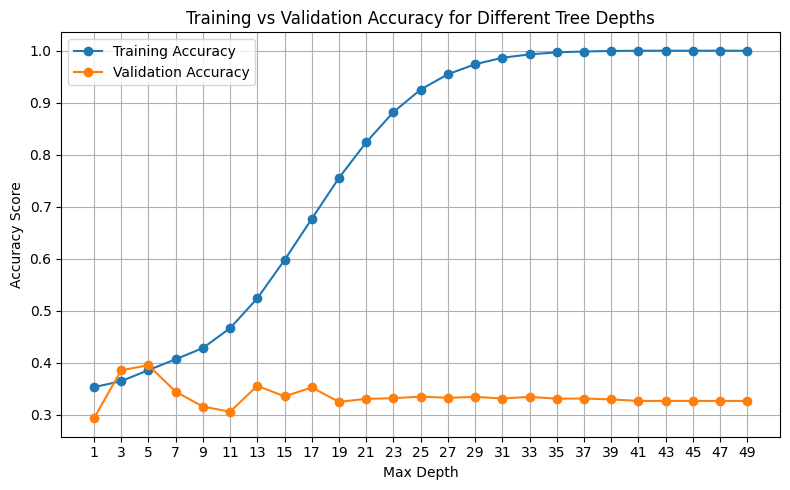

In [683]:
plt.figure(figsize=(8,5))

plt.plot(depth_hyperparams, training_acc, marker='o', label="Training Accuracy")
plt.plot(depth_hyperparams, validation_acc, marker='o', label="Validation Accuracy")


plt.xticks(depth_hyperparams)

plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Training vs Validation Accuracy for Different Tree Depths")

plt.grid(True)  # Add grid
plt.legend()
plt.tight_layout()
plt.show()


In [684]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [685]:
baseline_acc

np.float64(0.3400302441131994)

In [686]:
accuracy_score(y_train, model.predict(X_train))

0.38599333873435954

In [687]:
accuracy_score(y_val, model.predict(X_val))

0.3953551174723197

In [688]:
accuracy_score(y_test,model.predict(X_Test))

0.33153347732181426

In [689]:
print(classification_report(y_test,model.predict(X_Test)))

              precision    recall  f1-score   support

           0       0.32      0.39      0.35      1182
           1       0.35      0.50      0.41      1288
           2       0.30      0.10      0.15      1234

    accuracy                           0.33      3704
   macro avg       0.32      0.33      0.30      3704
weighted avg       0.32      0.33      0.30      3704

